In [2]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import easyocr
import torch
import webcolors
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time
from tqdm import tqdm
from selenium.webdriver.chrome.options import Options
import random

C:\Users\duwjd\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [25]:
df = pd.read_csv("video_datas.csv", encoding="utf-8-sig")
#df=df.iloc[:3,:]
print(len(df))
print(df.head())

9638
                                               title     video_id  \
0                                  결국 긴팔문신 제거 하는 조두팔  t-zwVkTOZA8   
1  [vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...  AMwSEsFVRGg   
2                             오사카&교토 브이로그 • 쇼핑에미띤여자들  PocqBywf0FU   
3  마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...  6eNhJ4LYr1k   
4  [썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...  G9tXGudpOCo   

  published_date                                      thumbnail_url  \
0       20250328  https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...   
1       20250328  https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...   
2       20250224  https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...   
3       20250329  https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...   
4       20250328  https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...   

   view_count  like_count  comment_count duration  \
0    244420.0         NaN          221.0     7:39   
1     11267.0       265.0           54.0    18:

In [5]:
print(df.isna().sum())
# print(set(df[df['channel_id'].str.contains('none', case=False, na=False)]['channel_id']))

title                 0
video_id              0
published_date        0
thumbnail_url         0
view_count            0
like_count          231
comment_count       620
duration              0
channel_id            0
subscriber_count      3
dtype: int64


In [27]:
# 조회수 낮은 데이터 제거
lower_threshold = df["view_count"].quantile(0.05)  # 하위 5%
df = df[df["view_count"] > lower_threshold]

# 구독자 수 적은 채널 삭제
df = df[df["subscriber_count"] > 500]

# 5년 이상 된 영상 제거 (현재 날짜 기준)
df["published_date"] = pd.to_datetime(df["published_date"])  # 날짜 변환
three_years_ago = pd.Timestamp.today() - pd.DateOffset(years=5)
df = df[df["published_date"] > three_years_ago]

# 업로드된 지 하루밖에 안 된 영상 삭제
one_day_ago = pd.Timestamp.today() - pd.DateOffset(days=3)
df = df[df["published_date"] < one_day_ago]

# 중복 데이터 제거
df = df.drop_duplicates()

# 결측값(NaN) 제거
# df = df.dropna()

# 영상 길이가 1분~60분이 아닌 데이터 삭제 (초 단위 기준)
import re

def convert_to_seconds(time_str):
    parts = list(map(int, re.findall(r'\d+', time_str)))  # 숫자만 추출
    
    if len(parts) == 3:  # HH:MM:SS 형식
        h, m, s = parts
    elif len(parts) == 2:  # MM:SS 형식
        h, m, s = 0, parts[0], parts[1]
    else:
        return np.nan  # 잘못된 형식 처리

    return h * 3600 + m * 60 + s  # 초 단위 변환

# 변환 적용
df["duration"] = df["duration"].astype(str).apply(convert_to_seconds)

# 변환 후, 영상 길이가 1분~1시간 범위 내에 있는 데이터만 유지
df = df[(df["duration"] >= 60) & (df["duration"] <= 3600)]

# 이상치(너무 높은 조회수, 너무 긴 영상) 제거
# 조회수 이상치 (상위 1% 이상 제거)
upper_threshold_views = df["view_count"].quantile(0.99)
df = df[df["view_count"] < upper_threshold_views]

# 영상 길이 이상치 (상위 1% 이상 제거)
upper_threshold_length = df["duration"].quantile(0.99)
df = df[df["duration"] < upper_threshold_length]

print("남은 데이터 개수:", len(df))

남은 데이터 개수: 7618


In [62]:
clean_df=pd.read_csv("cleaned_video_datas.csv", encoding="utf-8-sig")
clean_df=clean_df.iloc[3214:,:]

## 썸네일

In [68]:
# YOLO 모델 로드 (Ultralytics YOLOv5 예제)
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
ocr_reader = easyocr.Reader(['en', 'ko'])  # 영어 & 한글 OCR 지원

# 이미지 로드 (URL에서 다운로드)
def load_image_from_url(url):
    fallback_urls = [
        url,
        url.replace('maxresdefault', 'sddefault'),
        url.replace('sddefault', 'hqdefault'),
        url.replace('hqdefault', 'mqdefault'),
        url.replace('mqdefault', 'default')
    ]

    for new_url in fallback_urls:
        try:
            response = requests.get(new_url, stream=True, timeout=5)
            response.raise_for_status()
            image = np.asarray(bytearray(response.content), dtype=np.uint8)
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
            if image is not None:
                height, width, _ = image.shape
                return image, height, width
        except requests.RequestException:
            print(f"이미지 로드 실패: {new_url}")

    raise ValueError("모든 URL에서 이미지를 불러올 수 없습니다.")
    
# 이미지 전처리 (그레이스케일 + 이진화)
def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    denoised_image = cv2.GaussianBlur(binary_image, (5, 5), 0)
    return denoised_image

# 텍스트 분석 (OCR)
def extract_text(image, confidence_threshold=0.7):
    results = ocr_reader.readtext(image)
    text_info = []
    for (bbox, text, prob) in results:
        if prob >= confidence_threshold: 
            (top_left, _, bottom_right, _) = bbox
            x, y = int(top_left[0]), int(top_left[1])
            width = int(bottom_right[0] - top_left[0])
            height = int(bottom_right[1] - top_left[1])
            area = width * height
            
            text_info.append({
                "text": text,
                "x": x, "y": y,
                "width": width, "height": height,
                "area": area,
                "probability": prob 
            })
    return text_info

# 객체 탐지 (YOLO)
def detect_objects(image):
    if image is None:
        return {"objects": [], "central_focus": False}
    
    results = yolo_model(image)
    objects = []
    central_focus = False
    height, width, _ = image.shape
    
    for result in results.xyxy[0]:  # YOLOv5 결과
        x1, y1, x2, y2, conf, cls = map(int, result[:6])
        label = yolo_model.names[cls]
        
        # 객체의 중앙 여부 확인
        obj_center_x = (x1 + x2) / 2
        obj_center_y = (y1 + y2) / 2
        if (width * 0.3) < obj_center_x < (width * 0.7) and (height * 0.3) < obj_center_y < (height * 0.7):
            central_focus = True
        
        objects.append({"label": label, "x": x1, "y": y1, "width": x2-x1, "height": y2-y1})
    
    return {"objects": objects, "central_focus": central_focus}


# 주요 색상 추출 및 이름 변환
def closest_colour(requested_colour):
    """주어진 RGB 값과 가장 가까운 CSS3 색상명을 찾음"""
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_color_name_from_rgb(r, g, b):
    """정확한 색상이 있으면 반환, 없으면 가장 가까운 색상명 반환"""
    try:
        return webcolors.rgb_to_name((r, g, b), spec='css3')
    except ValueError:
        return closest_colour((r, g, b))

def extract_colors(image, num_colors=5):
    """이미지에서 주요 색상을 추출하고, 각 색상의 비율을 반환"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_colors, n_init="auto")
    labels = kmeans.fit_predict(image)
    palette = kmeans.cluster_centers_.astype(int)
    
    # 색상의 출현 빈도 계산
    counter = np.bincount(labels)
    total_count = np.sum(counter)
    # 주요 색상 및 비율 저장
    color_ratios = {tuple(palette[i]): counter[i] / total_count for i in range(len(palette))}
    # 색상명을 가져오도록 수정
    color_list = [(get_color_name_from_rgb(*color), ratio) for color, ratio in color_ratios.items()]
    
    return sorted(color_list, key=lambda x: x[1], reverse=True)

# 🔹 밝기 및 대비 계산
def calculate_brightness(image):
    return np.mean(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

def calculate_contrast(image):
    return np.std(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

# 🔹 전체 썸네일 분석 함수
def analyze_image(image_url):
    image, height, width = load_image_from_url(image_url)
    if image is None:
        return None
    
    # Step 1: 이미지 특성 추출 (색상, 밝기, 대비)
    colors = extract_colors(image)
    brightness = calculate_brightness(image)
    contrast = calculate_contrast(image)
    
    # Step 2: 이미지 전처리 후 OCR 텍스트 추출
    processed_image = preprocess_image(image)
    text_data = extract_text(processed_image, confidence_threshold=0.7)
    
    # Step 3: 객체 탐지 (YOLO)
    object_data = detect_objects(image)
    
    # 결과 리턴
    result = {
        "dominant_colors": colors,
        "brightness": brightness,
        "contrast": contrast,
        "text_details": text_data,
        "object_details": object_data
    }
    
    return result, height, width


clean_df['brightness'] = None
clean_df['contrast'] = None
clean_df['dominant_colors'] = None
clean_df['text_details'] = None
clean_df['objects_details'] = None
clean_df['thumbnail_size'] = None

for idx, image_url in tqdm(enumerate(clean_df['thumbnail_url'])):
    try:
        analysis_result, height, width = analyze_image(image_url)
        
        clean_df.at[idx+3214, 'brightness'] = analysis_result['brightness']
        clean_df.at[idx+3214, 'contrast'] = analysis_result['contrast']
        clean_df.at[idx+3214, 'dominant_colors'] = analysis_result['dominant_colors']
        clean_df.at[idx+3214, 'text_details'] = analysis_result['text_details']
        clean_df.at[idx+3214, 'objects_details'] = analysis_result['object_details']['objects']
        clean_df.at[idx+3214, 'thumbnail_size'] = (height, width)
        
    except Exception as e:
        print(f"[{idx}] 이미지 분석 실패: {image_url}\n오류: {e}")
        continue


Using cache found in C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-3-18 Python-3.11.7 torch-2.6.0+cu118 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
0it [00:00, ?it/s]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1it [00:07,  7.14s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2it [00:14,  7.43s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(ar

이미지 로드 실패: https://i.ytimg.com/vi/uuaRqx79fP8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
38it [04:54,  6.50s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
39it [05:02,  7.07s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
40it [05:10,  7.33s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autoca

이미지 로드 실패: https://i.ytimg.com/vi/q6CfUo3-nsI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
64it [08:19,  6.71s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
65it [08:27,  7.10s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
66it [08:35,  7.37s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autoca

이미지 로드 실패: https://i.ytimg.com/vi/UL5ul52MG9A/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
116it [15:14,  6.75s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
117it [15:22,  7.00s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
118it [15:30,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/tRi9ezt7X5o/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
259it [34:15,  6.46s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
260it [34:23,  6.97s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
261it [34:31,  7.26s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/nENtP7FEr8k/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
327it [43:08,  6.55s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
328it [43:16,  6.89s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
329it [43:24,  7.13s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/Ahpbc-SKlMI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
347it [45:41,  6.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
348it [45:49,  6.93s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
349it [45:56,  7.15s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/3Km26vEKES0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
382it [50:12,  6.32s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
383it [50:20,  6.79s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
384it [50:27,  7.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/HDgYIk-hZmo/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
390it [51:12,  6.64s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
391it [51:20,  7.19s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
392it [51:27,  7.18s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(aut

이미지 로드 실패: https://i.ytimg.com/vi/E0jUkRKY6nE/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
456it [59:48,  6.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
457it [59:56,  6.89s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
458it [1:00:03,  7.10s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(a

이미지 로드 실패: https://i.ytimg.com/vi/GQO9zIw0XXM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
485it [1:03:30,  6.57s/it]

이미지 로드 실패: https://i.ytimg.com/vi/LLcbCP0xI_g/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
486it [1:03:34,  5.55s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
487it [1:03:41,  6.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
488it [1:03:49,  6.71s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/I3elliGN87E/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
522it [1:08:14,  6.52s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
523it [1:08:22,  6.98s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
524it [1:08:30,  7.22s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/975ehqU5_Pg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
556it [1:12:50,  6.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
557it [1:12:58,  6.94s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
558it [1:13:06,  7.29s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/jPs3n9Vou9c/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
576it [1:15:46,  7.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
577it [1:15:54,  7.40s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
578it [1:16:02,  7.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/maxresdefault.jpg


590it [1:17:33,  5.97s/it]

이미지 로드 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/maxresdefault.jpg
[589] 이미지 분석 실패: https://i.ytimg.com/vi/iH0u7dnQGB8/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
591it [1:17:41,  6.52s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
592it [1:17:49,  6.87s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
593it [1:17:56,  7.06s/it]

이미지 로드 실패: https://i.ytimg.com/vi/3Ia93ZP6nPQ/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
594it [1:18:00,  5.97s/it]

이미지 로드 실패: https://i.ytimg.com/vi/CA5Ggqg5x6o/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
595it [1:18:03,  5.27s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
596it [1:18:12,  6.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
597it [1:18:20,  6.76s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/BWJWAdMZGNY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
607it [1:19:35,  6.46s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
608it [1:19:43,  6.88s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
609it [1:19:51,  7.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/rbwHyiD_djg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
655it [1:25:57,  6.82s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
656it [1:26:05,  7.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
657it [1:26:13,  7.32s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/-oHHf91uPv0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
690it [1:30:32,  6.70s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
691it [1:30:40,  6.94s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
692it [1:30:48,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/pEAazkz_tDY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
695it [1:31:08,  6.56s/it]

이미지 로드 실패: https://i.ytimg.com/vi/wdwHxyz3Hbo/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
696it [1:31:11,  5.65s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
697it [1:31:19,  6.26s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
698it [1:31:27,  6.69s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/RsS_0P6eNX0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
724it [1:34:58,  6.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
725it [1:35:06,  7.24s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
726it [1:35:14,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/MfGJMnZmIog/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
751it [1:38:32,  6.74s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
752it [1:38:41,  7.56s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
753it [1:38:49,  7.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/maxresdefault.jpg


769it [1:40:55,  6.05s/it]

이미지 로드 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/maxresdefault.jpg
[768] 이미지 분석 실패: https://i.ytimg.com/vi/KIpuTQUgdEg/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
770it [1:41:02,  6.55s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
771it [1:41:11,  7.01s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
772it [1:41:19,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/maxresdefault.jpg


853it [1:52:12,  6.13s/it]

이미지 로드 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/maxresdefault.jpg
[852] 이미지 분석 실패: https://i.ytimg.com/vi/t-XiAHjI5kg/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
854it [1:52:20,  6.69s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
855it [1:52:28,  6.96s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
856it [1:52:36,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/bqAqqRguDZs/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
891it [1:57:14,  6.54s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
892it [1:57:22,  6.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
893it [1:57:30,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/wZLwCFhPsb8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
973it [2:08:16,  6.49s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
974it [2:08:24,  6.95s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
975it [2:08:32,  7.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autoca

이미지 로드 실패: https://i.ytimg.com/vi/nDmX7IOgTcg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1015it [2:13:59,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1016it [2:14:08,  7.61s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1017it [2:14:16,  7.74s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/Nz75BVVZ5nw/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1183it [2:36:45,  6.53s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1184it [2:36:53,  7.03s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1185it [2:37:02,  7.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/rMfB7N7-Iek/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1216it [2:41:06,  6.38s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1217it [2:41:15,  6.95s/it]

이미지 로드 실패: https://i.ytimg.com/vi/kuiqUdD6IcU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1218it [2:41:18,  5.86s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1219it [2:41:25,  6.32s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1220it [2:41:33,  6.84s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/17QjZ5GeQRU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1236it [2:43:36,  6.56s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1237it [2:43:45,  7.26s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1238it [2:43:53,  7.50s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/DQ60qmrKUZI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1265it [2:47:24,  6.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1266it [2:47:32,  7.19s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1267it [2:47:41,  7.51s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/6Ww7QN5cA0E/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1292it [2:51:05,  6.94s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1293it [2:51:13,  7.44s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1294it [2:51:22,  7.79s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/maxresdefault.jpg


1333it [2:56:44,  6.24s/it]

이미지 로드 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/maxresdefault.jpg
[1332] 이미지 분석 실패: https://i.ytimg.com/vi/0M6iCHyg7BI/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1334it [2:56:53,  6.91s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1335it [2:57:01,  7.34s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1336it [2:57:09,  7.65s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/v9_hoR4LDWY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1364it [3:00:59,  6.73s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1365it [3:01:07,  7.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1366it [3:01:18,  8.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/w2YsywVMztI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1418it [3:08:36,  7.08s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1419it [3:08:44,  7.40s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1420it [3:08:52,  7.57s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/sgeA3GoEGf0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1449it [3:12:48,  6.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1450it [3:12:56,  7.13s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1451it [3:13:04,  7.37s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/56Lyo6Z9V-w/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1533it [3:24:40,  6.99s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1534it [3:24:48,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1535it [3:24:56,  7.49s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/zqKRV_DNCko/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1549it [3:26:47,  6.77s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1550it [3:26:56,  7.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1551it [3:27:04,  7.55s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/mQMa5WFY09w/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1574it [3:30:10,  6.83s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1575it [3:30:18,  7.19s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1576it [3:30:26,  7.55s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/b2s8CrAQyKw/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1645it [3:39:54,  6.78s/it]

이미지 로드 실패: https://i.ytimg.com/vi/b2s8CrAQyKw/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1646it [3:39:57,  5.77s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1647it [3:40:05,  6.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1648it [3:40:14,  7.02s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/maxresdefault.jpg


1665it [3:42:27,  6.17s/it]

이미지 로드 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/maxresdefault.jpg
[1664] 이미지 분석 실패: https://i.ytimg.com/vi/Fjba6jV7q8Q/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1666it [3:42:35,  6.70s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1667it [3:42:42,  7.07s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1668it [3:42:50,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/jQNNW_WgNQc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1682it [3:44:43,  6.84s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1683it [3:44:51,  7.11s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1684it [3:44:59,  7.36s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/-sBfJVnPguU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1748it [3:53:56,  6.81s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1749it [3:54:04,  7.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1750it [3:54:12,  7.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/Or2NE3pPiso/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1766it [3:56:21,  6.80s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1767it [3:56:29,  7.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1768it [3:56:37,  7.51s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/ERjxVA4mCRI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1822it [4:03:56,  6.72s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1823it [4:04:04,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1824it [4:04:12,  7.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/W1-m3db93GU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1859it [4:08:53,  6.71s/it]

이미지 로드 실패: https://i.ytimg.com/vi/ERjxVA4mCRI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1860it [4:08:56,  5.62s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1861it [4:09:05,  6.53s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1862it [4:09:13,  7.03s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/R_VTAPI3yjo/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1981it [4:25:58,  6.73s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1982it [4:26:06,  7.04s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
1983it [4:26:14,  7.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/N88fFYMn_SE/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2049it [4:35:10,  6.80s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2050it [4:35:18,  7.22s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2051it [4:35:27,  7.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/nszYjF9PCS8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2094it [4:41:15,  6.72s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2095it [4:41:23,  7.10s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2096it [4:41:31,  7.43s/it]

이미지 로드 실패: https://i.ytimg.com/vi/SqX2F8YhxBw/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2097it [4:41:34,  6.14s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2098it [4:41:42,  6.67s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2099it [4:41:50,  7.06s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/hagZ6FXSczg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2132it [4:46:16,  6.51s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2133it [4:46:24,  7.07s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2134it [4:46:32,  7.34s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/n2tF1Ysck6U/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2148it [4:48:24,  6.76s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2149it [4:48:32,  7.11s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2150it [4:48:40,  7.57s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/-bIHQQIh1fg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2290it [5:08:09,  6.78s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2291it [5:08:18,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2292it [5:08:26,  7.58s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/kqguRJ2MYJ8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2311it [5:11:00,  6.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2312it [5:11:08,  7.22s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2313it [5:11:17,  7.63s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/RlCVYjSdvpM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2329it [5:13:26,  6.95s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2330it [5:13:35,  7.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2331it [5:13:43,  7.61s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/-zkACkVgmqE/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2348it [5:15:57,  6.86s/it]

이미지 로드 실패: https://i.ytimg.com/vi/JuMmeRhv0Kg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2349it [5:16:00,  5.76s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2350it [5:16:09,  6.48s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2351it [5:16:17,  6.90s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/-njTHq-War0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2353it [5:16:29,  6.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2354it [5:16:37,  6.81s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2355it [5:16:45,  7.30s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/7JremAJnoII/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2390it [5:21:34,  6.73s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2391it [5:21:42,  7.15s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2392it [5:21:50,  7.37s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/vAlUswyzjWI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2444it [5:28:56,  6.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2445it [5:29:04,  7.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2446it [5:29:13,  7.57s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/0GN7wghTexU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2472it [5:32:43,  6.78s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2473it [5:32:51,  7.24s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2474it [5:33:00,  7.52s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/mIoBLS7X-p8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2512it [5:38:14,  6.99s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2513it [5:38:22,  7.36s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2514it [5:38:30,  7.52s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/cxUV_BRvbdc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2518it [5:38:58,  6.69s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2519it [5:39:07,  7.16s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2520it [5:39:15,  7.54s/it]

이미지 로드 실패: https://i.ytimg.com/vi/hjG6BmW-4gc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2521it [5:39:18,  6.31s/it]

이미지 로드 실패: https://i.ytimg.com/vi/L70O99O_WFM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2522it [5:39:22,  5.44s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2523it [5:39:30,  6.14s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2524it [5:39:38,  6.78s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/xFCuh_TuA5w/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2533it [5:40:49,  6.84s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2534it [5:40:57,  7.27s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2535it [5:41:05,  7.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/PHIYvES3cCI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2563it [5:44:55,  6.92s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2564it [5:45:03,  7.32s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2565it [5:45:12,  7.62s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/rPYA-Eq5bYM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2572it [5:46:05,  6.82s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2573it [5:46:13,  7.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2574it [5:46:22,  7.59s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/cxUV_BRvbdc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2600it [5:49:53,  6.95s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2601it [5:50:02,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2602it [5:50:10,  7.62s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/CA0JHDKKx0M/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2630it [5:54:03,  7.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2631it [5:54:11,  7.47s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2632it [5:54:20,  7.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/kBBz_Us3V18/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2724it [6:07:13,  6.93s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2725it [6:07:21,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2726it [6:07:29,  7.65s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/BDhWYnV0mj8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2739it [6:09:17,  6.94s/it]

이미지 로드 실패: https://i.ytimg.com/vi/v9_hoR4LDWY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2740it [6:09:20,  5.80s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2741it [6:09:28,  6.49s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2742it [6:09:36,  6.97s/it]

이미지 로드 실패: https://i.ytimg.com/vi/tFn5IHMAuwI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2743it [6:09:40,  5.88s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2744it [6:09:48,  6.53s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
2745it [6:09:56,  7.04s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/bTYEi-d3UCQ/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3147it [7:06:15,  6.61s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3148it [7:06:23,  7.03s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3149it [7:06:32,  7.38s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/XrwmY743_Uk/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3181it [7:10:55,  7.57s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3182it [7:11:04,  7.72s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3183it [7:11:12,  8.02s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.aut

이미지 로드 실패: https://i.ytimg.com/vi/k-Rr6vr1vB0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3204it [7:14:09,  7.39s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3205it [7:14:18,  7.74s/it]

이미지 로드 실패: https://i.ytimg.com/vi/rganxE9Bkp0/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/rganxE9Bkp0/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/rganxE9Bkp0/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/rganxE9Bkp0/maxresdefault.jpg


3206it [12:07:55, 5290.66s/it]

이미지 로드 실패: https://i.ytimg.com/vi/rganxE9Bkp0/maxresdefault.jpg
[3205] 이미지 분석 실패: https://i.ytimg.com/vi/rganxE9Bkp0/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3207it [12:08:12, 3708.58s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3208it [12:08:23, 2599.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3209it [12:08:34, 1822.68s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  wit

이미지 로드 실패: https://i.ytimg.com/vi/IIqNJ-bmVjQ/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3213it [12:09:08, 443.26s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3214it [12:09:17, 313.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3215it [12:09:27, 222.00s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with a

이미지 로드 실패: https://i.ytimg.com/vi/30ffe3GI-lY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3270it [12:16:33,  7.75s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3271it [12:16:41,  7.70s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3272it [12:16:49,  7.83s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/t5vJCBcrKho/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3274it [12:17:01,  6.74s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3275it [12:17:09,  7.03s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3276it [12:17:17,  7.33s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/L-REk97e-gA/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3281it [12:17:51,  6.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3282it [12:18:00,  6.86s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3283it [12:18:07,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/hHnMxcAwnYU/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3294it [12:19:32,  6.69s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3295it [12:19:40,  7.16s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3296it [12:19:48,  7.40s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/g92eim_rVk4/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3298it [12:20:00,  6.51s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3299it [12:20:08,  6.98s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3300it [12:20:16,  7.22s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/MNkOwBIhRug/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/MNkOwBIhRug/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/MNkOwBIhRug/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/MNkOwBIhRug/maxresdefault.jpg


3389it [12:32:35,  5.96s/it]

이미지 로드 실패: https://i.ytimg.com/vi/MNkOwBIhRug/maxresdefault.jpg
[3388] 이미지 분석 실패: https://i.ytimg.com/vi/MNkOwBIhRug/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3390it [12:32:44,  6.78s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3391it [12:32:51,  7.11s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3392it [12:33:00,  7.53s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/pKPKsNH7L80/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3526it [12:51:36,  6.91s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3527it [12:51:45,  7.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3528it [12:51:53,  7.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/eZRAsH6N0fc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3564it [12:56:49,  6.77s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3565it [12:56:57,  7.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3566it [12:57:06,  7.77s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/EWDcQmv2fn8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3665it [13:10:52,  6.96s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3666it [13:11:00,  7.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3667it [13:11:09,  7.75s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/DOskT1tHSPw/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3693it [13:14:41,  6.78s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3694it [13:14:49,  7.16s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3695it [13:14:58,  7.53s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/uy4Wi_1Zxj0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3735it [13:20:28,  6.86s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3736it [13:20:36,  7.24s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3737it [13:20:44,  7.49s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/maxresdefault.jpg


3749it [13:22:15,  6.03s/it]

이미지 로드 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/maxresdefault.jpg
[3748] 이미지 분석 실패: https://i.ytimg.com/vi/nDyy1Y3zMNs/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3750it [13:22:23,  6.62s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3751it [13:22:31,  7.06s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3752it [13:22:39,  7.38s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/WDsPrpOcpz0/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3762it [13:23:58,  6.81s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3763it [13:24:06,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3764it [13:24:14,  7.39s/it]

이미지 로드 실패: https://i.ytimg.com/vi/1tQhZ5wKthg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3765it [13:24:17,  6.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3766it [13:24:24,  6.58s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3767it [13:24:33,  7.16s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/yeTa0ZsTOcY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3772it [13:25:08,  6.43s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3773it [13:25:16,  6.92s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3774it [13:25:24,  7.26s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/AkEOierPVkU/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/AkEOierPVkU/sddefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/AkEOierPVkU/maxresdefault.jpg


3776it [13:25:34,  5.70s/it]

이미지 로드 실패: https://i.ytimg.com/vi/AkEOierPVkU/maxresdefault.jpg
이미지 로드 실패: https://i.ytimg.com/vi/AkEOierPVkU/maxresdefault.jpg
[3775] 이미지 분석 실패: https://i.ytimg.com/vi/AkEOierPVkU/maxresdefault.jpg
오류: 모든 URL에서 이미지를 불러올 수 없습니다.


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3777it [13:25:42,  6.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3778it [13:25:50,  6.90s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3779it [13:25:58,  7.19s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/Vm9_bgqa9UQ/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3789it [13:27:14,  6.57s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3790it [13:27:23,  7.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3791it [13:27:31,  7.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/x1CX8rK2vJM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3797it [13:28:13,  6.43s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3798it [13:28:21,  6.93s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3799it [13:28:29,  7.24s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/xGQtTfQmsSc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3894it [13:41:36,  6.86s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3895it [13:41:44,  7.30s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3896it [13:41:53,  7.76s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/acVPCHfntGg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3900it [13:42:21,  6.75s/it]

이미지 로드 실패: https://i.ytimg.com/vi/BxvIpiSl3lo/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3901it [13:42:25,  5.71s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3902it [13:42:33,  6.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3903it [13:42:41,  7.10s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/blIppAXegjI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3917it [13:44:35,  7.01s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3918it [13:44:43,  7.30s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3919it [13:44:52,  7.74s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/Qg6XG48Osss/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3976it [13:52:53,  7.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3977it [13:53:01,  7.46s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3978it [13:53:10,  7.91s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/eiU4k7LcyqY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3981it [13:53:30,  6.76s/it]

이미지 로드 실패: https://i.ytimg.com/vi/dgZiJzLsmg4/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3982it [13:53:35,  6.21s/it]

이미지 로드 실패: https://i.ytimg.com/vi/EcuKknoTZxM/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3983it [13:53:39,  5.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3984it [13:53:47,  6.31s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3985it [13:53:55,  6.77s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/o4rA7aeMAIY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3987it [13:54:09,  6.64s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3988it [13:54:17,  7.04s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
3989it [13:54:25,  7.41s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/u-UX5zTFpN4/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4005it [13:56:34,  7.05s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4006it [13:56:42,  7.44s/it]

이미지 로드 실패: https://i.ytimg.com/vi/rbkbOBukRhg/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4007it [13:56:46,  6.16s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4008it [13:56:54,  6.88s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4009it [13:57:02,  7.20s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/zQohyXiecaY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4023it [13:58:54,  6.95s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4024it [13:59:03,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4025it [13:59:11,  7.71s/it]

이미지 로드 실패: https://i.ytimg.com/vi/GZ1xpqx-8H8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4026it [13:59:15,  6.45s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4027it [13:59:23,  6.96s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4028it [13:59:31,  7.38s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/tT8sqBY6KBc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4041it [14:01:14,  6.66s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4042it [14:01:22,  7.17s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4043it [14:01:30,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/sH-gyK5gAWA/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4052it [14:02:40,  6.75s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4053it [14:02:48,  7.13s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4054it [14:02:57,  7.58s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/LcfBf_8cKi4/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4064it [14:04:14,  6.69s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4065it [14:04:23,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4066it [14:04:31,  7.48s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/G7VJdg25c5w/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4094it [14:08:20,  6.86s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4095it [14:08:28,  7.32s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4096it [14:08:37,  7.63s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/QnE90j0YIdY/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4121it [14:12:02,  7.25s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4122it [14:12:11,  7.64s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4123it [14:12:19,  7.99s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/_BWqPkO4cXI/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4133it [14:13:42,  7.23s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4134it [14:13:50,  7.50s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4135it [14:13:59,  7.81s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/ALVWSmMTYro/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4193it [14:22:02,  7.00s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4194it [14:22:10,  7.34s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4195it [14:22:19,  7.81s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/nwlzRyOb8zc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4206it [14:23:55,  8.06s/it]

이미지 로드 실패: https://i.ytimg.com/vi/RlSe92Q-Klk/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4207it [14:23:58,  6.75s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4208it [14:24:07,  7.33s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4209it [14:24:17,  8.09s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/75cBkdlvWro/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4212it [14:24:38,  6.91s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4213it [14:24:46,  7.42s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4214it [14:24:55,  7.85s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/PobNw4AWYPc/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4237it [14:28:01,  6.87s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4238it [14:28:10,  7.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4239it [14:28:19,  7.73s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/P3yaa66F_No/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4261it [14:31:18,  6.84s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4262it [14:31:26,  7.17s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4263it [14:31:35,  7.52s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/UtCoFL6qB6w/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4307it [14:37:46,  6.92s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4308it [14:37:54,  7.22s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4309it [14:38:03,  7.49s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/F_ikCRugzNo/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4343it [14:42:46,  6.87s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4344it [14:42:54,  7.19s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4345it [14:43:03,  7.63s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/UGnZFs0ISOs/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4353it [14:44:05,  6.80s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4354it [14:44:14,  7.30s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4355it [14:44:22,  7.54s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

이미지 로드 실패: https://i.ytimg.com/vi/KyNdN6IjVy8/maxresdefault.jpg


C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4385it [14:48:36,  7.13s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4386it [14:48:44,  7.35s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
4387it [14:48:52,  7.68s/it]C:\Users\duwjd/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:894: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.

In [45]:
#df.to_csv("thumbnail_all_video_datas.csv", index=False, encoding="utf-8-sig")

In [90]:
df=pd.read_csv("thumbnail_all_video_datas.csv", encoding="utf-8-sig")
df = df.dropna(subset=["thumbnail_size", "text_details", "objects_details"]).reset_index(drop=True)

In [92]:
def classify_positions(image_width, image_height, text_details, object_details):
    def classify_position(x, y, width, height):
        """ 위치를 왼쪽/중간/오른쪽, 위/중간/아래, 크기별로 분류 """
        right_x = x + width
        bottom_y = y + height

        # 가로 위치 (left, middle, right)
        if right_x < image_width * 0.33:
            horizontal_position = "left"
        elif x > image_width * 0.67:
            horizontal_position = "right"
        else:
            horizontal_position = "middle"

        # 세로 위치 (up, middle, down)
        if bottom_y < image_height * 0.33:
            vertical_position = "up"
        elif y > image_height * 0.67:
            vertical_position = "down"
        else:
            vertical_position = "middle"

        # 크기 분류 (s, m, l)
        area = width * height
        size_category = "s" if area < 10000 else ("m" if area < 30000 else "l")

        return f"{horizontal_position} {vertical_position} {size_category}"

    # Text 위치 분석
    text_positions = [classify_position(td['x'], td['y'], td['width'], td['height']) for td in text_details]
    if not text_positions:  # 텍스트가 없을 경우
        text_positions = ["텍스트 없음"]

    # Person 위치 분석
    person_positions = [
        classify_position(obj['x'], obj['y'], obj['width'], obj['height'])
        for obj in object_details if obj['label'] == 'person'
    ]
    if not person_positions:  # 사람 객체가 없을 경우
        person_positions = ["사람 없음"]

    # 신뢰도 높은 텍스트 추출 (probability ≥ 0.7)
    high_confidence_texts = [td["text"] for td in text_details if td.get("probability", 0) >= 0.7]
    prob_text = high_confidence_texts if high_confidence_texts else ["해당 없음"]

    return text_positions, person_positions, prob_text

def extract_labels(obj_detail_str):
    try:
        objects = ast.literal_eval(obj_detail_str)
        labels = [obj["label"] for obj in objects if "label" in obj]
        return labels if labels else ["없음"]
    except:
        return ["에러"]

df["object_labels"] = df["objects_details"].apply(extract_labels)


df[["text_positions", "person_positions", "prob_text"]] = df.apply(
    lambda row: pd.Series(
        classify_positions(
            image_width=ast.literal_eval(row["thumbnail_size"])[1],   # width
            image_height=ast.literal_eval(row["thumbnail_size"])[0],  # height
            text_details=ast.literal_eval(row["text_details"]),
            object_details=ast.literal_eval(row["objects_details"])
        )
    ),
    axis=1
)



In [93]:
del df['text_details']
del df['objects_details']

In [96]:
df.to_csv("cleaned_thumbnail_video_datas.csv", index=False, encoding="utf-8-sig")

## 제목

In [ ]:
df=pd.read_csv("cleaned_thumbnail_video_datas.csv", encoding="utf-8-sig")

In [188]:
from collections import Counter
from konlpy.tag import Okt
import emoji

# 형태소 분석기 초기화
okt = Okt()

# 불용어 리스트
stopwords = set([
    '은', '는', '이', '가', '을', '를', '에', '의', '도', '로', '과', '와', '한', '하다',
    '에서', '에게', '까지', '부터', '보다', '처럼', '만', '없이', '수', '것', '좀', '더', '이',
    '또', '등', '그', '이것', '저것', '그것', '거', '때', '건', '중', '나', '너', '저', '우리',
    '누구', '뭐', '왜', '어디', '어떻게', '영상', '채널', '오늘', '이제', '정말', '진짜',
    '완전', '그냥', '내가', '당신', '내용', '제목', '시작', '끝', '다시', '모두',
    '최고', '대박', '소름', '헐', 'ㅋㅋ', 'ㅎㅎ', 'ㅠㅠ', '와우','자막','브이','로그','일상'
    '정보', '필독', '업로드', '자막', '구독', '좋아요', '댓글', '시청', '확인',
    '보세요'
])

# 클릭 유도 키워드
clickbait_keywords = [
    '실화', '충격', '대박', '소름', '반전', '최초', '드디어', '헐', '진실',
    '믿기지', '이게', '무조건', '죽기 전에', '꼭 봐야할'
]

# 피처 추출 함수
def extract_korean_title_features(title, video_id):
    features = {}
    features['video_id'] = video_id
    features['title'] = title
    features['title_length'] = len(title)
    features['word_count'] = len(okt.morphs(title))

    # 이모지 관련 피처
    features['emoji_count'] = sum(1 for char in title if char in emoji.EMOJI_DATA)
    features['has_emoji'] = int(features['emoji_count'] > 0)

    # 특수문자 수
    special_chars = re.findall(r"[!\"#$%&'()*+,\-./:;<=>?@\[\]^_`{|}~]", title)
    features['special_char_count'] = len(special_chars)

    # 클릭 유도 키워드 포함 여부
    features['is_clickbait'] = int(any(word in title for word in clickbait_keywords))

    # 구두점 포함 여부
    features['has_question_mark'] = '?' in title
    features['has_exclamation'] = '!' in title

    # 주요 명사 3개 추출 (불용어 제거 포함)
    nouns = okt.nouns(title)
    filtered_nouns = [noun for noun in nouns if noun not in stopwords and len(noun) > 1]
    noun_freq = Counter(filtered_nouns)
    top_nouns = [word for word, _ in noun_freq.most_common(3)]
    for i in range(3):
        features[f'top_noun_{i+1}'] = top_nouns[i] if i < len(top_nouns) else ''

    return features

titles = df['title']
video_ids = df['video_id']

# 피처 추출 실행
feature_df = pd.DataFrame([
    extract_korean_title_features(title, video_id)
    for title, video_id in zip(titles, video_ids)
])

# 출력
print(feature_df.head())

      video_id                                              title  \
0  t-zwVkTOZA8                                  결국 긴팔문신 제거 하는 조두팔   
1  AMwSEsFVRGg  [vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...   
2  PocqBywf0FU                             오사카&교토 브이로그 • 쇼핑에미띤여자들   
3  6eNhJ4LYr1k  마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...   
4  G9tXGudpOCo  [썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...   

   title_length  word_count  emoji_count  has_emoji  special_char_count  \
0            17           9            0          0                   0   
1            98          37            3          1                   9   
2            22          12            0          0                   1   
3            99          50            1          1                   4   
4            55          32            3          1                   5   

   is_clickbait  has_question_mark  has_exclamation top_noun_1 top_noun_2  \
0             0              False            False      

In [196]:
#feature_df.to_csv("title_video_datas.csv", index=False, encoding="utf-8-sig")

## 썸네일 & 제목 피쳐 합치기

In [198]:
thumbnail_df=pd.read_csv("cleaned_thumbnail_video_datas.csv", encoding="utf-8-sig")
feature_df=pd.read_csv("title_video_datas.csv", encoding="utf-8-sig")
print(len(thumbnail_df))
print(len(feature_df))

7591
7591


In [200]:
thumbnail_df_unique = thumbnail_df.drop_duplicates(subset='video_id')
feature_df_unique = feature_df.drop_duplicates(subset='video_id')

merge_df = pd.merge(thumbnail_df_unique, feature_df_unique, how='inner', on='video_id')
merge_df = merge_df[merge_df['title_x'].str.contains(r'[가-힣]', regex=True)]
len(merge_df)

7308

In [204]:
#merge_df.to_csv("final_video_datas.csv", index=False, encoding="utf-8-sig")

## 피쳐 구성 파악

In [202]:
merge_df.describe(include='all')

,title_x,video_id,published_date,thumbnail_url,view_count,like_count,comment_count,duration,channel_id,subscriber_count,...,word_count,emoji_count,has_emoji,special_char_count,is_clickbait,has_question_mark,has_exclamation,top_noun_1,top_noun_2,top_noun_3
count,7308,7308,7308,7308,7.308000e+03,7175.000000,7121.000000,7308.000000,7308,7.308000e+03,...,7308.000000,7308.000000,7308.000000,7308.000000,7308.000000,7308,7308,7283,7128,6846
unique,7289,7308,1073,7308,NaN,NaN,NaN,NaN,2453,NaN,...,NaN,NaN,NaN,NaN,NaN,2,2,2789,3106,3158
top,[12뉴스] 오늘의 주요뉴스 / SBS,t-zwVkTOZA8,2025-03-28,https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...,NaN,NaN,NaN,NaN,"(' YTN', '@ytnnews24')",NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,테슬라,버라이어티,하바나
freq,11,1,221,1,NaN,NaN,NaN,NaN,201,NaN,...,NaN,NaN,NaN,NaN,NaN,5861,5578,284,101,67
mean,NaN,NaN,NaN,NaN,6.481823e+05,9409.151916,782.451341,925.517378,NaN,1.517002e+06,...,19.960865,0.351259,0.197729,4.297072,0.057745,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.460531e+06,29279.895063,3528.673610,709.398507,NaN,3.908397e+06,...,9.051113,0.860403,0.398314,3.278131,0.233276,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,4.320000e+02,0.000000,0.000000,60.000000,NaN,5.280000e+02,...,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,3.151825e+04,466.500000,62.000000,355.750000,NaN,1.190000e+05,...,14.000000,0.000000,0.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.465250e+05,2099.000000,205.000000,780.000000,NaN,4.610000e+05,...,19.000000,0.000000,0.000000,4.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.055885e+05,7457.500000,664.000000,1301.000000,NaN,1.880000e+06,...,25.000000,0.000000,0.000000,6.000000,0.000000,NaN,NaN,NaN,NaN,NaN


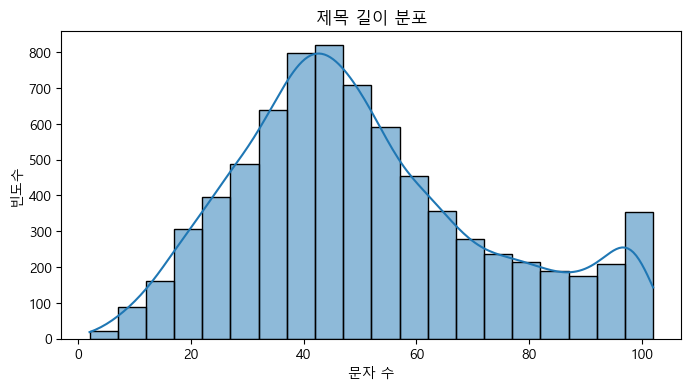

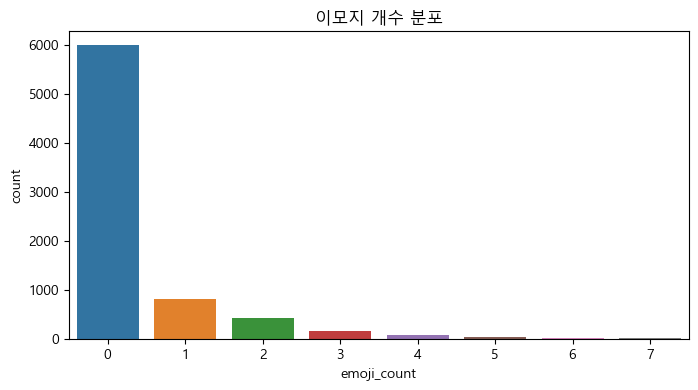

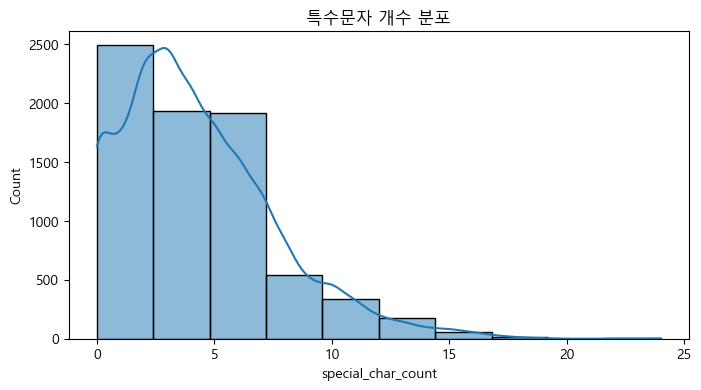

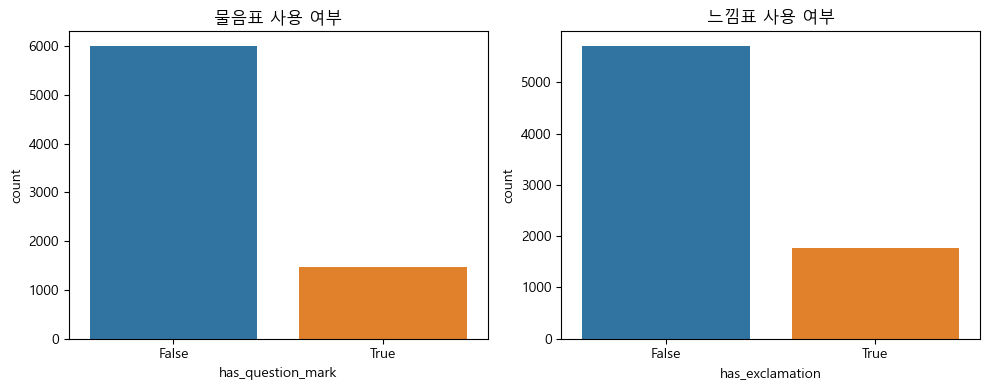

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc("font", family="Malgun Gothic")

# 1. 제목 길이 분포
plt.figure(figsize=(8, 4))
sns.histplot(feature_df['title_length'], bins=20, kde=True)
plt.title('제목 길이 분포')
plt.xlabel('문자 수')
plt.ylabel('빈도수')
plt.show()

# 2. 이모지 개수 분포
plt.figure(figsize=(8, 4))
sns.countplot(x='emoji_count', data=feature_df)
plt.title('이모지 개수 분포')
plt.show()

# 3. 특수문자 개수 분포
plt.figure(figsize=(8, 4))
sns.histplot(feature_df['special_char_count'], bins=10, kde=True)
plt.title('특수문자 개수 분포')
plt.show()

# 4. 물음표 / 느낌표 사용 비율
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x='has_question_mark', data=feature_df, ax=axs[0])
axs[0].set_title('물음표 사용 여부')

sns.countplot(x='has_exclamation', data=feature_df, ax=axs[1])
axs[1].set_title('느낌표 사용 여부')

plt.tight_layout()
plt.show()


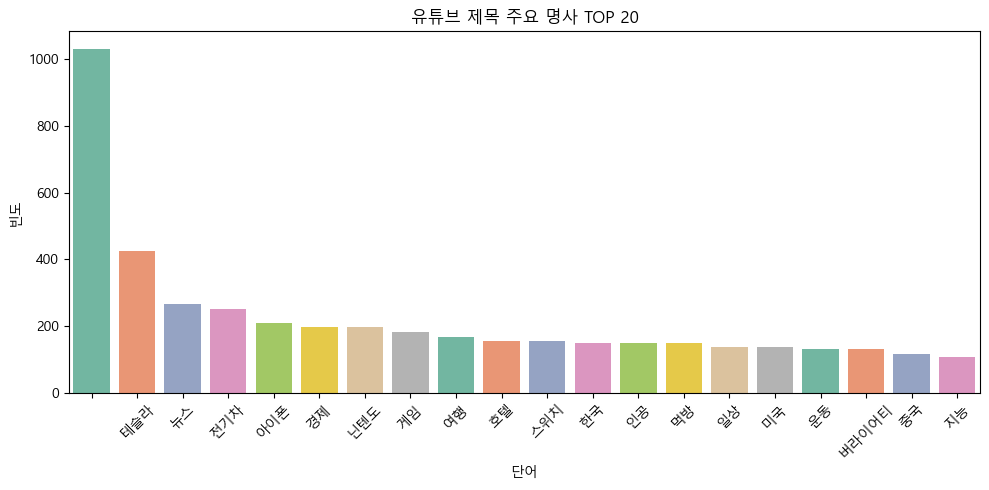

In [192]:
# 1. 주요 명사 리스트 합치기
noun_columns = ['top_noun_1', 'top_noun_2', 'top_noun_3']
all_nouns = feature_df[noun_columns].values.flatten()  # 2D -> 1D로
all_nouns = [noun for noun in all_nouns if pd.notna(noun)]  # 결측값 제거

# 2. 명사 빈도 계산
noun_counts = Counter(all_nouns)

# 3. 상위 20개 명사 추출
top_nouns_df = pd.DataFrame(noun_counts.most_common(20), columns=['단어', '빈도'])

# 4. 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=top_nouns_df, x='단어', y='빈도', palette='Set2')
plt.title('유튜브 제목 주요 명사 TOP 20')
plt.xlabel('단어')
plt.ylabel('빈도')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# EDA

In [207]:
merge_df.iloc[10,:]

title_x                                                 쉽지 않은 결정을 했습니다.
video_id                                                    q1pQcnMFoCg
published_date                                               2025-03-03
thumbnail_url         https://i.ytimg.com/vi/q1pQcnMFoCg/maxresdefau...
view_count                                                     490806.0
like_count                                                       2389.0
comment_count                                                       NaN
duration                                                          547.0
channel_id                               ('이봉조봉커플', '@bongbong_couple')
subscriber_count                                                68600.0
brightness                                                   142.650315
contrast                                                      75.693823
dominant_colors       [('silver', 0.30349175347222224), ('grey', 0.1...
thumbnail_size                                              (720